### Teste de hipotese

Esse notebook tem por objetivo detectar varios pontos e gerar um descritor otimo que seja resitente a variacoes de transformacoes afins e pequenas transformacoes projetivas, para isso temos:

-- BaseFeatures para extrair informacoes equivariantes (num_channels,dim_first,dim_second,dim_third).

-- SingularPoints lida com escala , e extrai as features consolidadas, em dim_third caracteristicas distintas, orientacao computadas além da lista de pontos.

-- Computa a funcao de perda entre os mapas de orientacao e feature e os pontos que colidiram

In [1]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [ ]:
import torch
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
import numpy as np

In [ ]:
from config import args, device
def custom_config(args):
    args.num_channels = 1
    args.img_size = 120
    args.dim_first = 3
    args.dim_second = 5
    args.dim_third = 8
    args.batch_size = 14
    args.margin_loss = 2.0
    args.border_size  = 12
    args.nms_size = 5 # normal é 10, alterei so pra avaliar o match
    args.box_size = 21
    args.exported = False
    return args

POINTS_LIMIT = 90
THRESHOLD_COLLISION = 1.0
args = custom_config(args)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
def criar_mascara(size_batch,dimensao_janela, tamanho_borda):
    
    mascara = torch.zeros((size_batch,1, dimensao_janela, dimensao_janela), dtype=torch.uint8)
    mascara[..., tamanho_borda:-tamanho_borda, tamanho_borda:-tamanho_borda] = 1

    return mascara.to(torch.float32)

In [ ]:
class MaxPointDetector:
    """
    Class for detecting maximum points in images or tensors.

    Methods:
    - detect_max_points: Applies a maximum point filter on a batch of images.
    - filter_coordinates: Filters coordinates in a tensor based on image and channel indices.
    - Sorts the rows of a matrix based on the last element of each row.
    """

    def detect_max_points(self, images, size=15, threshold=1e-3):
        width, height = images.shape[-2:]
        max_map = F.max_pool2d(images, size, stride=1, padding=(size - 1) // 2)

        max_coords = (max_map > threshold) & (max_map == images)
        max_coords = max_coords.nonzero()
        max_values = max_map[max_coords[:, 0], max_coords[:, 1], max_coords[:, 2], max_coords[:, 3]]

        max_coords_values = torch.cat((max_coords, max_values.unsqueeze(1)), dim=1)
        max_coords_values = max_coords_values[:, [0, 1, 3, 2, 4]]  # trocando x e y de ordem antes de concatenar

        # Filtrar coordenadas na borda
        mask = (
            (max_coords_values[:, 2] >= args.border_size) &  # Verificar limite esquerdo
            (max_coords_values[:, 2] < (width - args.border_size)) &  # Verificar limite direito
            (max_coords_values[:, 3] >= args.border_size) &  # Verificar limite superior
            (max_coords_values[:, 3] < (height - args.border_size ))  # Verificar limite inferior
        )
        max_coords_values = max_coords_values[mask]

        return max_coords_values, max_map.squeeze().numpy()

    def sort_tensor_by_columns(self,tensor):
        # Ordena pela última coluna
        sorted_indices = torch.argsort(tensor[:, -1],descending=True)
        tensor_sorted_by_last_column = tensor[sorted_indices]
        return tensor_sorted_by_last_column

    def filter_coordinates(self, tensor, image_index, channel_index):
        # Filter the values where the image and channel indices are equal to the provided values
        mask = (tensor[:, 0] == image_index) & (tensor[:, 1] == channel_index)
        filtered_coords = torch.masked_select(tensor[:, 2:], mask.unsqueeze(1)).reshape(-1, 3)
        return filtered_coords


def check_valid_points(points, mask):
    # Check limits of points
    height_mask, width_mask = mask.shape[-2:]
    limits_valid = (points[..., 0].long() >= 0) & (points[..., 0].long() < width_mask) & (points[..., 1].long() >= 0) & (points[..., 1].long() < height_mask)

    # Check if points are within the mask region with value equal to 1
    mask_valid = torch.ones_like(limits_valid)
    if mask is not None:
        mask_valid = mask[..., points[..., 1].long().unsqueeze(-1), points[..., 0].long().unsqueeze(-1)] == 1

    # Combine the checks to get the valid points
    valid_points = points[limits_valid & mask_valid.squeeze()]

    return valid_points

In [ ]:
r2_act = gspaces.Rot2dOnR2(N=args.group_size)#N=8 is the number of Groups equivariant
OUT_SHAPE = args.img_size
#This model is base to build the model for singular points detection e orientation estimation
class BaseFeatures(nn.Module):
    #This model extract 8 features from the image
    def __init__(self, args) -> None:
        super().__init__()
        self.pyramid_levels = args.pyramid_levels
        self.scale = args.scale_pyramid
        self.feat_type_in = enn.FieldType(r2_act, args.num_channels * [
            r2_act.trivial_repr])  ## input 1 channels (gray scale image)

        #feat_type_out1 = enn.FieldType(r2_act, args.dim_first * [r2_act.regular_repr])
        feat_type_out1 = enn.FieldType(r2_act, args.dim_second * [r2_act.regular_repr])
        feat_type_out2 = enn.FieldType(r2_act, args.dim_second * [r2_act.regular_repr])
        feat_type_out3 = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])

        self.block1 = enn.SequentialModule(
            enn.R2Conv(self.feat_type_in, feat_type_out1, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out1),
            enn.ReLU(feat_type_out1, inplace=True),
        )
        self.block2 = enn.SequentialModule(
            enn.R2Conv(feat_type_out1, feat_type_out2, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out2),
            enn.ReLU(feat_type_out2, inplace=True)
        )
        self.block3 = enn.SequentialModule(
            enn.R2Conv(feat_type_out2, feat_type_out3, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out3),
            enn.ReLU(feat_type_out3, inplace=True),
            enn.PointwiseAdaptiveAvgPool(feat_type_out3,OUT_SHAPE),
        )

    def forward(self, x):
        x = enn.GeometricTensor(x, self.feat_type_in)
        x = self.block1(x)
        # x = self.block2(x)
        x = self.block3(x)
        return x


In [ ]:
import torch.nn.functional as F
from kornia import filters

class SingularPoints(nn.Module):
    def __init__(self,args) -> None:
        super().__init__()
        print(args)
        self.in_type = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])
        feat_type_ori_est = enn.FieldType(r2_act, [r2_act.regular_repr])

        self.pyramid_levels = args.pyramid_levels
        self.scale_pyramid = args.scale_pyramid
        self.n_channel = args.num_channels

        self.base = BaseFeatures(args)

        self.gpool = enn.GroupPooling(self.in_type)#feature pooling
        self.ori_learner = enn.SequentialModule(
            enn.R2Conv(self.in_type, feat_type_ori_est, kernel_size=1, padding=0, bias=False),
            ## Channel pooling by 8*G -> 1*G conv.
        )#orientation estimation

        self.softmax = torch.nn.Softmax(dim=1)
        self.last_layer_features = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third * self.pyramid_levels),
            torch.nn.Conv2d(in_channels=args.dim_third * self.pyramid_levels, out_channels=args.dim_third, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )

        self.features_summary = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third),
            torch.nn.Conv2d(in_channels=args.dim_third, out_channels=1, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )

        self.detector = MaxPointDetector()

    def resize_pyramid(self,idx_level,input_data):
        # sigma_unit = 0.2 *(idx_level+1)
        # gaussian = filters.GaussianBlur2d((3, 3), (sigma_unit, sigma_unit))
        gaussian = filters.GaussianBlur2d((3, 3), (0.9, 0.9))
        input_data_blur = gaussian(input_data)

        size = np.array(input_data.shape[-2:])
        new_size = (size / (self.scale_pyramid ** idx_level)).astype(int)

        input_data_resized = F.interpolate(input_data_blur, size=tuple(new_size), align_corners=True, mode='bilinear')
        return input_data_resized

    def compute_gradient_direction(self,orie_img_batch):
        _b,_na,_c,_r=orie_img_batch.shape #bacth,num degree,col,row
        ori_arg_max= torch.argmax(orie_img_batch, dim=1)
        bin_size = 360/_na
        ori_arg_max=ori_arg_max*bin_size # direcao do gradiente
                                # para cada pixel
        ori_arg_max=ori_arg_max[None].permute(1, 0, 2, 3)
        return ori_arg_max

    def forward(self,x)->torch.Tensor:
        for idx_level in range(self.pyramid_levels):
            with torch.no_grad():
                input_data_resized = self.resize_pyramid(idx_level,x)
            x_base = self.base(input_data_resized)

            features_t = self.gpool(x_base).tensor# C*G -> 1*C
            features_o = self.ori_learner(x_base).tensor # C*G -> 1*G

            if idx_level == 0:
                features_key = features_t
                features_ori = features_o
            else:
                features_key = torch.cat([features_key, features_t], axis=1)  # concatena no eixo X (S*C)
                features_ori = torch.add(features_ori, features_o)  # somatorio dos kernels
            # print('features_key ',features_key.shape,' features_ori ',features_ori.shape) #TODO: remover

        features_key = self.last_layer_features(features_key)#(S*C)->(1*C)
        features_key_summary = self.features_summary(features_key)#(C)->(1)

        features_ori = self.softmax(features_ori)
        features_ori_summary = self.compute_gradient_direction(features_ori)



        return  features_key,features_key_summary,features_ori,features_ori_summary


model=SingularPoints(args).to(device)

Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=14, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/miniconda3/envs/singular-points/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647327249/work/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [ ]:

from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import time

def medir_tempo(linha_codigo):
    start_time = time.time()
    resultado = linha_codigo()
    end_time = time.time()
    execution_time = end_time - start_time
    return resultado, execution_time

def plot_images_side_by_side(tensor_images):
    b, x, y = tensor_images.shape

    # Criar uma figura e eixos para o plot
    fig, axes = plt.subplots(1, b, figsize=(b*3, 3))

    # Loop sobre as imagens e plotar cada uma em um eixo separado
    for i in range(b):
        # Obter a imagem atual
        image = tensor_images[i]

        # Plotar a imagem no eixo correspondente
        axes[i].imshow(image, cmap='gray')  # Defina cmap='gray' se as imagens forem em escala de cinza
        axes[i].axis('off')  # Desabilitar os eixos

    # Exibir o plot
    plt.show()

def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1.cpu(), image2.cpu()), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1.cpu()):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='g',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='g',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2.cpu()):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='g',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='g',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


def find_best_matching_indices_knn(points1, points2, threshold, k=3):
    distances = cdist(points1, points2)
    best_indices = np.argsort(distances, axis=1)[:, :k]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    matched = []

    for i in range(len(points1)):
        min_distance = np.min(best_distances[i])
        if min_distance < threshold:
            best_index = np.argmin(best_distances[i])
            matched.append((i, best_indices[i, best_index]))

    return matched


def find_matching_in_batch(batch_points1, batch_points2, threshold):
    # Lista para armazenar as correspondências
    lista_correspondencias = []

    # Iterar sobre o lote de pontos
    for i in range(batch_points1.shape[0]):
        # Obter os pontos correspondentes entre duas imagens
        correspondencias = find_best_matching_indices_knn(batch_points1[i], batch_points2[i], threshold, k=2)
        print("correspondencias ",correspondencias)
        print("pontos " + str(batch_points1[i]))
        lista_correspondencias.append(correspondencias)

    return lista_correspondencias

def predict_all_points(input_data,mask):
    features_key,features_key_summary,features_ori,features_ori_summary = model(input_data*mask)
    max_coords_values, max_map = model.detector.detect_max_points(features_key_summary.cpu().detach(),size=args.nms_size)
    max_coords_temp = model.detector.sort_tensor_by_columns(max_coords_values)
    batch_size = features_key.shape[0]
    batch_points = torch.zeros((batch_size,POINTS_LIMIT, 2))
    for i in range(batch_size):
        max_coords_temp2 = model.detector.filter_coordinates(max_coords_temp, image_index=i, channel_index=0)[:POINTS_LIMIT, :2]

        try:
            batch_points[i,:max_coords_temp2.shape[0]] = max_coords_temp2
        except:
            print(max_coords_temp2.shape,batch_points.shape)
            print('nao tem pontos suficientes')
    return features_key_summary,features_ori_summary,batch_points


def predict_all_descritor(input_data,mask):
    features_key,features_key_summary,features_ori,features_ori_summary = model(input_data*mask)
    max_coords_values, max_map = model.detector.detect_max_points(features_key_summary.cpu().detach(),size=args.nms_size)
    max_coords_temp = model.detector.sort_tensor_by_columns(max_coords_values)
    batch_size = features_key.shape[0]
    batch_points = torch.zeros((batch_size,POINTS_LIMIT, 2))
    for i in range(batch_size):
        max_coords_temp2 = model.detector.filter_coordinates(max_coords_temp, image_index=i, channel_index=0)[:POINTS_LIMIT, :2]

        try:
            batch_points[i,:max_coords_temp2.shape[0]] = max_coords_temp2
        except:
            print(max_coords_temp2.shape,batch_points.shape)
            print('nao tem pontos suficientes')
    return features_key,features_ori,batch_points

### Predizer Segrega os pontos para cada imagem do batch

In [ ]:
torch.cuda.empty_cache()

X1=torch.rand(4,args.num_channels,args.img_size,args.img_size).to(device)
mask = criar_mascara(X1.shape[0],X1.shape[-1],args.border_size).to(device)
print("mask.shape:", mask.shape)

features_key_summary,features_ori_summary,batch_points=predict_all_points(X1,mask)
print(features_key_summary.shape,features_ori_summary.shape,batch_points.shape)
# batch_t,mask_t,features_summary_t,features_ori_t,batch_points_t = transformations(X1,mask,features_summary,features_ori,batch_points.to(device))# transformar orientacoes e pontos
print("features_summary.shape:", features_key_summary.shape," batch_points.shape:", batch_points.shape)


mask.shape: torch.Size([4, 1, 120, 120])
torch.Size([4, 1, 120, 120]) torch.Size([4, 1, 120, 120]) torch.Size([4, 90, 2])
features_summary.shape: torch.Size([4, 1, 120, 120])  batch_points.shape: torch.Size([4, 90, 2])


### Aplicar transformação na imagem e suas predicoes

In [ ]:
import kornia.augmentation as K
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input', 'keypoints']  # Especificando as chaves de dados
)
out,mask_trans, transform = transformations(X1,mask,batch_points.to(device))  # 2x3x224x224 / 2x3x3
# prever os pontos da imagem transformada
features_key_summary2,features_ori_summary2,batch_points2 =predict_all_points(out,mask_trans)
print("features_summary2.shape:", features_key_summary2.shape," batch_points2.shape:", batch_points2.shape)

features_summary2.shape: torch.Size([4, 1, 120, 120])  batch_points2.shape: torch.Size([4, 90, 2])


points1.shape: (90, 2)  points2.shape: (90, 2)
points1[0] -> points2[23]
points1[1] -> points2[24]
points1[3] -> points2[22]
cuda:0 cuda:0 cuda:0


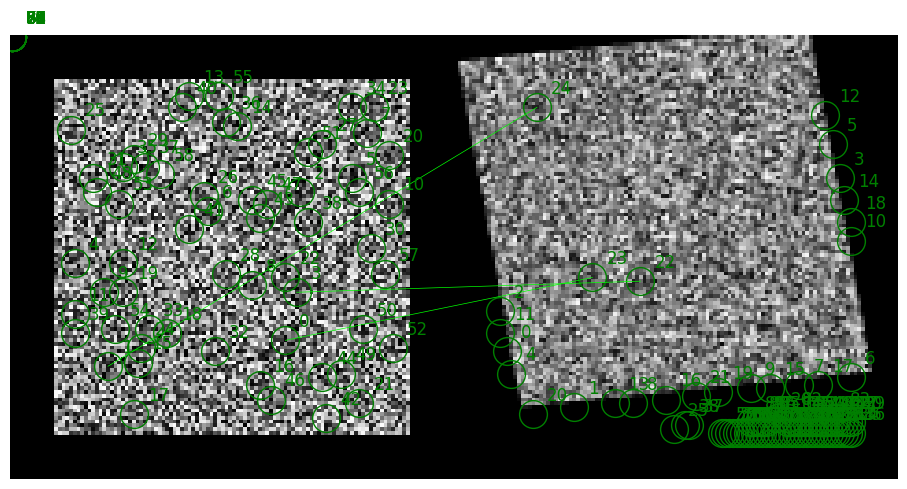

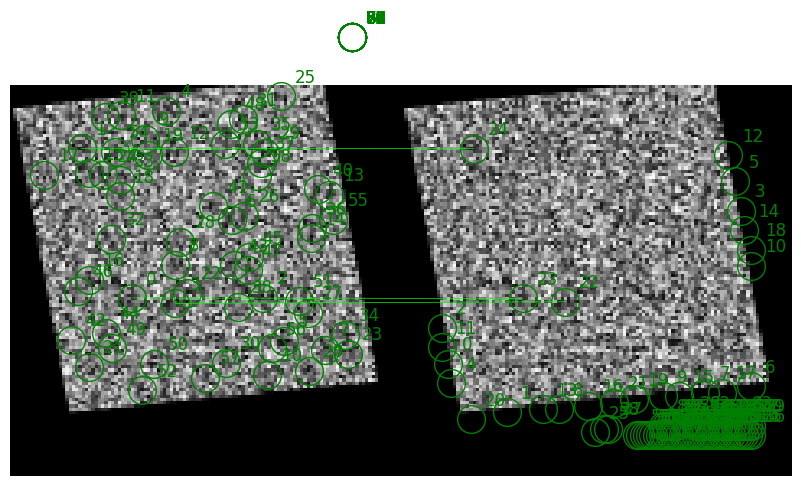

In [ ]:
# Exemplo de uso
points1 = transform[0].cpu().numpy()
points2 = batch_points2[0].cpu().numpy()
threshold = 2.0
print("points1.shape:", points1.shape," points2.shape:", points2.shape)
matched = find_best_matching_indices_knn(points1, points2, threshold,k=3)
for (idx1,idx2) in matched:
    print(f"points1[{idx1}] -> points2[{idx2}]")

print(mask_trans.device,transform.device,mask.device)
plot_matches_keypoints(X1[0,0]*mask[0,0], batch_points[0].cpu(), out[0,0]*mask_trans[0,0], batch_points2[0].cpu(),matched)
plot_matches_keypoints(out[0,0]*mask_trans[0,0], transform[0].cpu(), out[0,0]*mask_trans[0,0], batch_points2[0].cpu(),matched)

### Treinamento

In [ ]:
import math
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode

transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])


trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                        shuffle=False, num_workers=2)

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                        download=True, transform=transform)

num_datapoints_to_keep = math.ceil(len(testset) / 2)
indices_to_keep = torch.randperm(num_datapoints_to_keep)[:num_datapoints_to_keep]
reduced_testset = torch.utils.data.Subset(testset, indices_to_keep)
testloader = torch.utils.data.DataLoader(reduced_testset, batch_size=args.batch_size,
                                        shuffle=False, num_workers=2)


In [ ]:
from tqdm.notebook import tqdm
import gc
from training import triplet_loss
from training.tensor_augmetation import shifted_batch_tensor

transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
    K.RandomPerspective(0.2, p=0.7),
    K.RandomBoxBlur((4,4),p=0.5),
    same_on_batch=True,
    data_keys = ['input','input','input', 'input','keypoints']  # Especificando as chaves de dados
)

def train_one_epoch(model, train_loader, loss_map, optimizer=None, device='cpu', transformations=None,is_training=True):
    model.train(is_training) # Set model to training mode
    total_loss = 0.
    desc="Train " if is_training else "Test "
    t = tqdm(train_loader, desc=desc)
    batch_i = 0
    loss_maps = 0.
    for batch_image, labels in t:
        batch_image = batch_image.to(device)
        mask = criar_mascara(batch_image.shape[0],batch_image.shape[-1],args.border_size).to(device)
        features_key_summary,features_ori_summary,batch_points=predict_all_points(batch_image,mask)
        batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t = transformations(batch_image,mask,features_key_summary,features_ori_summary,batch_points.to(device))# transformar orientacoes e pontos
        features_key_summary_t2,features_ori_summary_t2,batch_points_t2 =predict_all_points(batch_t,mask_t)# prever os pontos da imagem transformada
        # lista_correspondencias = find_matching_in_batch(batch_points_t2.cpu(),batch_points_t.cpu(),threshold=THRESHOLD_COLLISION)

        batch_image_neg_trans, features_key_summary_neg, features_ori_summary_neg = shifted_batch_tensor(batch_t, features_key_summary_t2,
                                                                    features_ori_summary_t2)  # faz o shift com o comando roll(x,1,0)

        loss_maps = loss_map(features_key_summary_t,features_key_summary_t2,features_key_summary_neg)+loss_map(features_ori_summary_t,features_ori_summary_t2,features_ori_summary_neg)
        # loss_col = loss_point(batch_points_t2.cpu(),batch_points_t.cpu(),threshold=1)
        # loss = loss_maps/2+ loss_col
        loss = loss_maps/2

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        batch_i += 1 # Incrementa o contador de batches

        avg_loss = total_loss / batch_i  # Calcula a média acumulada
        t.set_description("{} Loss: {:.5f}".format(desc,avg_loss))
        del features_key_summary, features_ori_summary, batch_points
        del batch_t, mask_t, features_key_summary_t, features_ori_summary_t, batch_points_t
        del features_key_summary_t2, features_ori_summary_t2, batch_points_t2
        gc.collect()
        torch.cuda.empty_cache()
        
    return avg_loss


criterion_d = triplet_loss(is_ssim=args.is_loss_ssim, margim=args.margin_loss)
#criterion_d = triplet_loss(is_ssim=False, margim=args.margin_loss)

In [ ]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")


# teste = model.copy()
path_siamese = './data/models/sp2_no_repetition.pth'#maps+col


In [ ]:
gc.collect()
torch.cuda.empty_cache()
args.epochs=32
i_epoch = 0
loss = 0
optimizer = optim.Adam(model.parameters(), lr=0.0025, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.80)

import torch

def train_with_early_stopping(model, trainloader, testloader, criterion_d, optimizer, scheduler, device, transformations, epochs=100, patience=20):
    best_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0

    for epoch in range(epochs):
        # Atualizar a taxa de aprendizado
        if (epoch % 5 == 0) and (epoch != 0):
            scheduler.step()
            torch.save(best_model,'./data/models/sp2_mp_{}.pth'.format(epoch))
            print("salvou no colab")

        running_loss = train_one_epoch(model, trainloader, loss_map=criterion_d,optimizer=optimizer, device=device, transformations=transformations, is_training=True)

        with torch.no_grad():
            loss_test = train_one_epoch(model, testloader, loss_map=criterion_d,optimizer=None, device=device, transformations=transformations, is_training=False)

        # Verificar se a perda melhorou
        if loss_test < best_loss:
            best_loss = loss_test
            epochs_without_improvement = 0
            best_model = model.state_dict()
        else:
            epochs_without_improvement += 1

        # Verificar a condição de parada
        if epochs_without_improvement == patience:
            print(f"No improvement in loss for {epochs_without_improvement} epochs. Training stopped.")
            break

        print(f"Epoch [{epoch}/{epochs}] - Running Loss: {running_loss:.4f}, Test Loss: {loss_test:.4f}, Initial LR: {optimizer.param_groups[0]['initial_lr']:.6f}, Current LR: {optimizer.param_groups[0]['lr']:.6f}, Epochs without Improvement: {epochs_without_improvement}")


    # Carregar a melhor configuração do modelo
    model.load_state_dict(best_model)
    print(f'Epoch: {epoch}, Best Loss: {best_loss:.4f}')



In [ ]:
train_with_early_stopping(model, trainloader, testloader, criterion_d, optimizer, scheduler, device, transformations, epochs=args.epochs, patience=30)
save_model(model,path_siamese)

Train :   0%|          | 0/73 [00:00<?, ?it/s]

Test :   0%|          | 0/220 [00:00<?, ?it/s]

Epoch [0/32] - Running Loss: 1.8560, Test Loss: 1.8188, Initial LR: 0.005000, Current LR: 0.005000, Epochs without Improvement: 0


Train :   0%|          | 0/73 [00:00<?, ?it/s]

Test :   0%|          | 0/220 [00:00<?, ?it/s]

Epoch [1/32] - Running Loss: 1.8107, Test Loss: 1.8256, Initial LR: 0.005000, Current LR: 0.005000, Epochs without Improvement: 1


Train :   0%|          | 0/73 [00:00<?, ?it/s]

Test :   0%|          | 0/220 [00:00<?, ?it/s]

Epoch [2/32] - Running Loss: 1.8328, Test Loss: 1.8134, Initial LR: 0.005000, Current LR: 0.005000, Epochs without Improvement: 0


Train :   0%|          | 0/73 [00:00<?, ?it/s]

Test :   0%|          | 0/220 [00:00<?, ?it/s]

Epoch [3/32] - Running Loss: 1.8125, Test Loss: 1.8153, Initial LR: 0.005000, Current LR: 0.005000, Epochs without Improvement: 1


Train :   0%|          | 0/73 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# load_model(model,path_siamese)
# save_model(model,path_siamese)

In [ ]:
# path_siamese = './data/models/sp_52.pth'
# model = SingularPoints(args=args).to(device)
# l


### Avaliacao da correspondencia da posicao dos pontos

In [ ]:
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape,labels.shape)
img = img.to(device)
model.eval()
with torch.no_grad():
  mask = criar_mascara(img.shape[0],img.shape[-1],args.border_size).to(device)
  features_key_summary,features_ori_summary,batch_points=predict_all_points(img,mask)         
  batch_t,mask_t,features_key_summary_t,features_ori_summary_t,batch_points_t = transformations(img,mask,features_key_summary,features_ori_summary,batch_points.to(device))# transformar orientacoes e pontos
  features_key_summary_t2,features_ori_summary_t2,batch_points_t2 =predict_all_points(batch_t,mask_t)# prever os pontos da imagem transformada
  


torch.Size([14, 1, 120, 120]) torch.Size([14])


correspondencias  [(0, np.int64(0)), (1, np.int64(1)), (2, np.int64(1)), (3, np.int64(5)), (4, np.int64(6)), (5, np.int64(4)), (6, np.int64(8)), (7, np.int64(4)), (8, np.int64(9)), (9, np.int64(2)), (10, np.int64(18)), (11, np.int64(7)), (12, np.int64(3)), (13, np.int64(12)), (14, np.int64(21)), (15, np.int64(28)), (16, np.int64(17)), (17, np.int64(25)), (18, np.int64(10)), (19, np.int64(6)), (20, np.int64(24)), (22, np.int64(20)), (23, np.int64(13)), (24, np.int64(11)), (25, np.int64(11)), (26, np.int64(22)), (29, np.int64(31)), (30, np.int64(14)), (32, np.int64(26)), (33, np.int64(16)), (37, np.int64(15)), (38, np.int64(45)), (39, np.int64(27)), (40, np.int64(30)), (41, np.int64(23)), (42, np.int64(29)), (43, np.int64(35)), (45, np.int64(37)), (46, np.int64(35)), (48, np.int64(32)), (49, np.int64(32)), (50, np.int64(34)), (52, np.int64(38)), (53, np.int64(33)), (54, np.int64(40)), (55, np.int64(44)), (56, np.int64(36)), (57, np.int64(47)), (59, np.int64(44)), (60, np.int64(50)), (61,

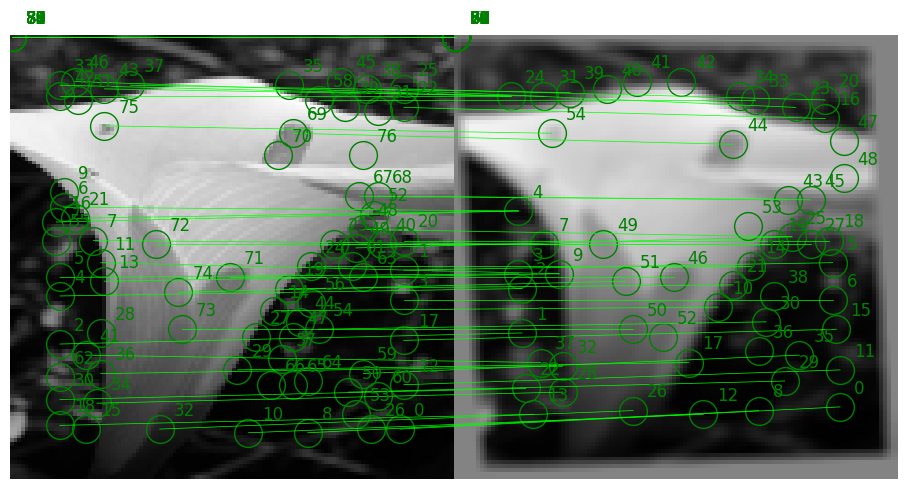

NameError: name 'loss_point' is not defined

In [ ]:
INDEX =1
lista_correspondencias = find_matching_in_batch(batch_points_t.cpu(),batch_points_t2.cpu(),threshold=4)  
acertos = 0
for correspondencias in lista_correspondencias:
  acertos +=len(correspondencias)

q,p,_ = batch_points_t.shape
total = q*p
print("total de pontos {} acertos {} -- %{}".format(total,acertos,acertos*100/total))

print(batch_points_t2.shape,batch_points_t.shape)
for (idx1,idx2) in lista_correspondencias[INDEX]:
    print(f"points1[{idx1}] -> points2[{idx2}]")
print(f"qtd acertos {len(lista_correspondencias[INDEX])}")
plot_matches_keypoints(img[INDEX].permute(1,2,0), batch_points[INDEX].cpu(), batch_t[INDEX].permute(1,2,0), batch_points_t2[INDEX].cpu(),lista_correspondencias[INDEX])

loss_col = loss_point(lista_correspondencias,n_pontos=POINTS_LIMIT)
loss_col